# Ses Sinyal İşleme ve Sınıflandırma
Ses Sinyallerin özniteliklerini (coefficients) analiz etmek. bunu da MFC ve python modülü olan librosa kullanarak yaptım.  Mel-Frequency Cepstral Coefficients(MFCC) larını çıkarttım.
MFC coefficient larını kullanarak ses dosyalarının özniteliklerini extract ettim.

UrbanSound8K Dataset: https://goo.gl/8hY5ER

Ses bir sinyaldir ve bu sinyallerin karakteristik özellikleri vardır. Her sesin farklı karakteristiği var. Derin öğrenme kullanarak ses sinyalleri üzerinde sınıflandırma yapmamızın yolu da bu sesleri işlemekten ve özniteliklerini almaktan geçiyor. Yapay zeka uygulamadan önce ses dosyalarımızın özniteliklerini bulmamız gerek.
Librosa kütüphanesi MFC coefficient larını çıkartmamızı sağlayan python kütüphanesidir.

In [2]:
import tensorflow as tf # 2.4.0 üzeri version olmalı
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
import seaborn as sns
import IPython.display as ipd

In [5]:
# libosa kullanarak analiz edilecek ses dosyasının alınması
audio_file_path='UrbanSound8K/UrbanSound8K/children.wav' 
# libosa.loab fun cile hem ses dosyasını hem de sample rate bilgisibi veriyor
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [6]:
# tek boyutlu bir array, liste. Librosa bu ses dosyasını dijital hale getirdi.
# librosonun bir özelliği de bu ses dosyalarını mono olarak okuyabiliyor.
# librosa bu stereo ses dosyasını mono hale çeviriyor. stereo seslerde sol ve sağ ses kanalları olmak üzere 2 kanal var.
# librosa 2 kanalı birleştiriyor tek kanallı bir ses sinyali haline getiriyor.
print(librosa_audio_data)

[ 0.0591024   0.04647241 -0.02115159 ... -0.0069612   0.03259261
  0.09148587]


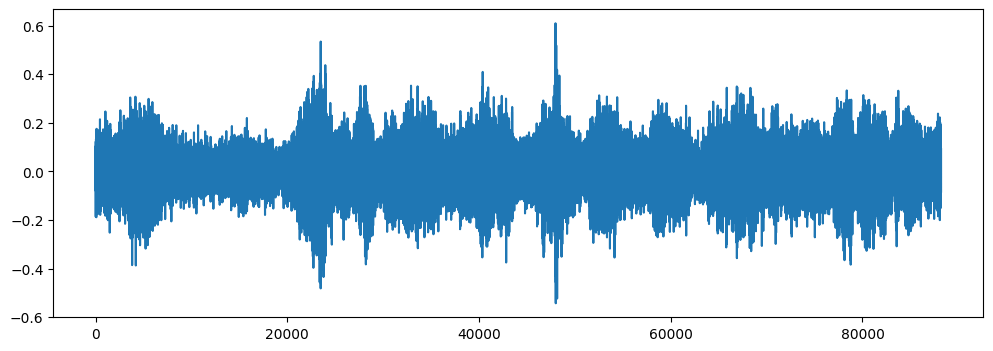

In [7]:
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
plt.show()

In [8]:
# librosa kullanmadan önce orjinal ses dosyasının 2 kanallı olduğunu görelim.
# scipy.io kullanmıyoruz çünkü onun feature extarction MFC coefficient özelliği yok.
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [9]:
wave_audio

array([[2189, 3314],
       [1592, 2598],
       [ 848, 1712],
       ...,
       [1326, 2602],
       [1915, 3542],
       [2542, 4449]], dtype=int16)

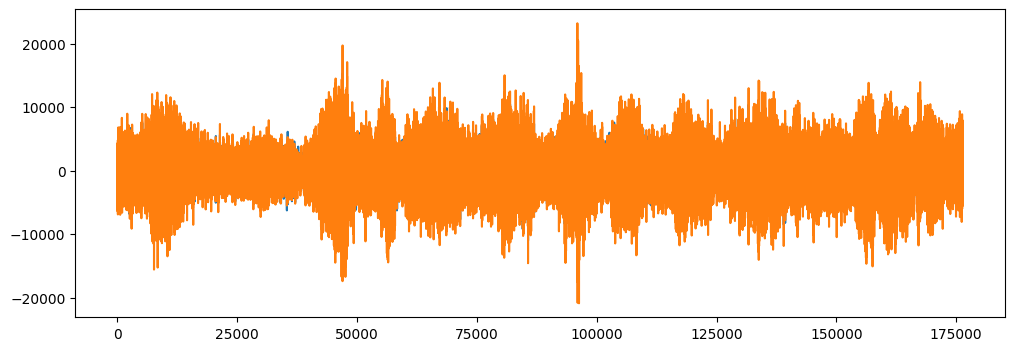

In [10]:
wave_sample_rate, wave_audio = wav.read(audio_file_path)
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)
plt.show()
# altta 2. kanal mavi ile gösterilmiş ama biri daha baskın olduğu için üst üste gelmiş.

In [11]:
# n_mfcc = default 20. Verdiğimiz sinyalden kaç tane coefficient çıkartacağını belirlediğimiz değer. Ne kadar çok coeff. çıkartırsak o kadar iyi sonuç alırız ama çok zaman alır
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=60)
print(mfccs.shape)
# parametreleri verdikten sonra mfcc leri çıkartıyorum ve shape ine bakıyorum

(60, 173)


In [12]:
mfccs

array([[-166.06232  , -151.50264  , -172.7387   , ..., -192.53252  ,
        -179.10657  , -179.59177  ],
       [  75.67847  ,   93.39499  ,  109.31447  , ...,  107.66586  ,
          87.264244 ,   67.258606 ],
       [-107.505295 , -118.782585 , -128.7536   , ..., -112.772415 ,
         -97.96594  ,  -85.718735 ],
       ...,
       [   2.87998  ,    3.2812428,    2.267674 , ...,   -2.504728 ,
           1.1422688,    2.6234105],
       [   1.9014561,    1.1560519,   -1.8486075, ...,   -1.3668318,
          -1.0525832,    1.3352302],
       [   1.3158615,    5.1257896,    2.9651809, ...,   -1.4735026,
          -3.2485921,   -6.1915784]], dtype=float32)

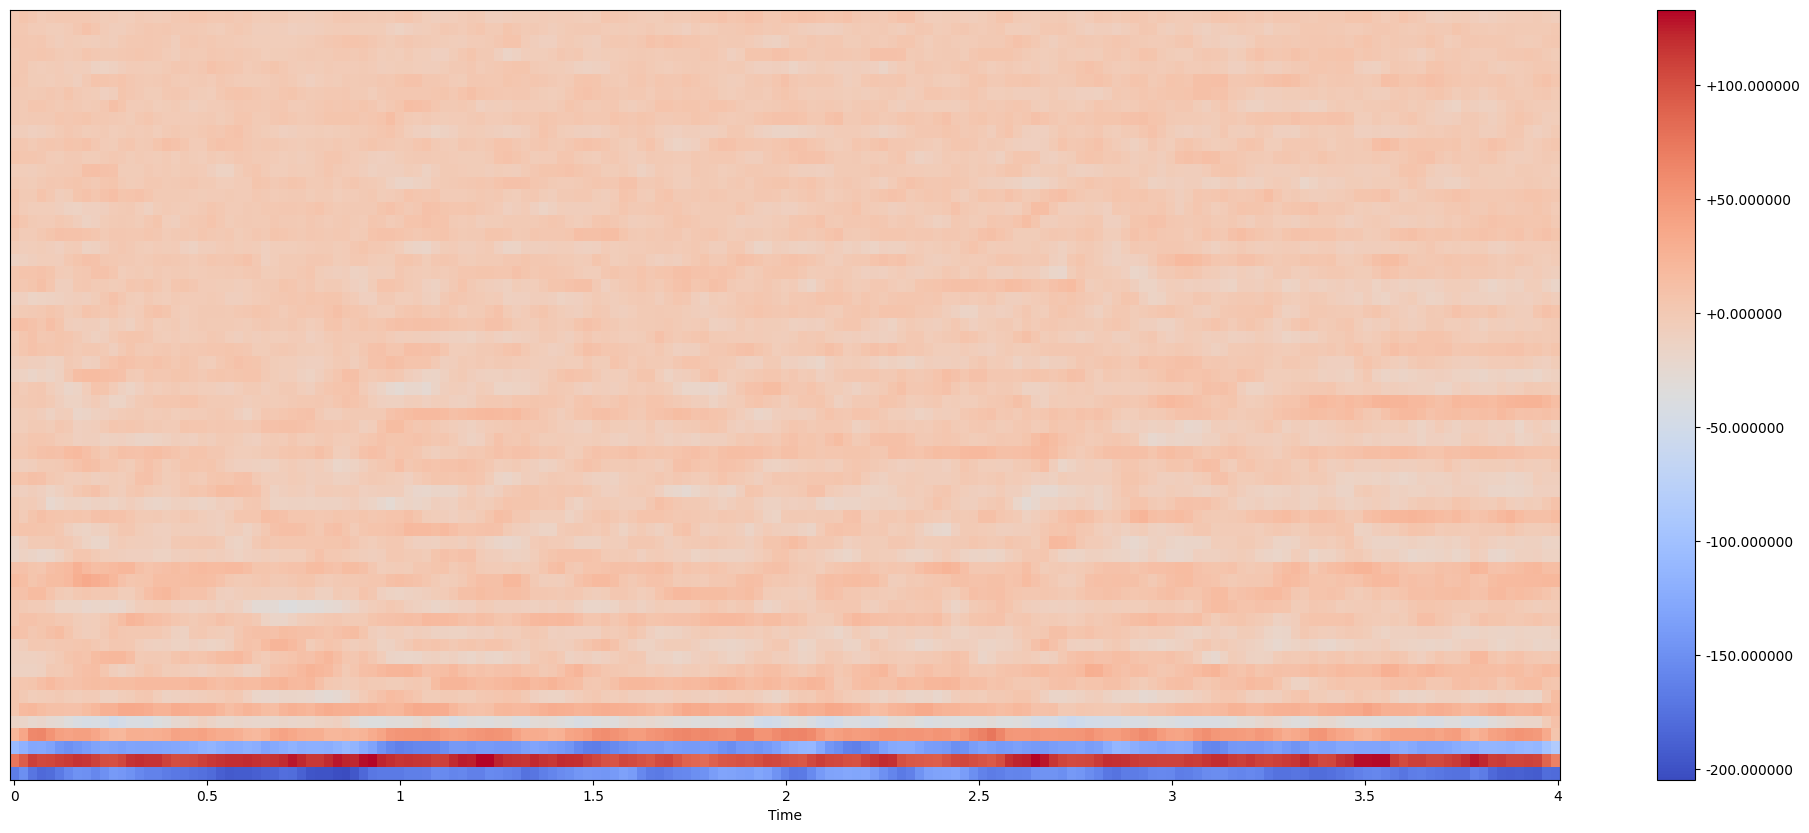

In [13]:
# MFCC yi görselleştirmek
plt.figure(figsize=(25,10))
librosa.display.specshow(mfccs,x_axis="time",sr=librosa_sample_rate)
plt.colorbar(format="%+2f")
plt.show()

In [14]:
# Dosyadaki tüm seslere bu MFCC işlemini uygulamamız gerekiyor.

audio_dataset_path = 'UrbanSound8K/UrbanSound8K/audio/'
metadata = pd.read_csv('UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()
# meta data içinde tüm ses dosyaları hakkında bilgiler her alıyor en önemli bilgiler. file name ve o sesin hangi class a ait olduğunu gösteren class sütunu

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [15]:
# yukarıda tek bir ses dosyası için yaptım MFCC işlemini tüm dosyalar için yapan fonksiyon
def features_extractor(filename):
    audio, sample_rate = librosa.load(filename, res_type = 'kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 60)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0) # scaling işlemi
    
    return mfccs_scaled_features

In [16]:
# audio dosyası içindeki tüm ses dosyalarını tek tek dolaşıp özellik yani öznitelik çıkarımı yaptım.
extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), 'fold' + str(row["fold"]) + '/', str(row["slice_file_name"]))
    final_class_labels = row["class"]
    data = features_extractor(file_name)
    extracted_features.append([data, final_class_labels])

3553it [02:52, 22.74it/s]C:\Users\ntatlici\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8325it [07:08, 23.93it/s]C:\Users\ntatlici\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
C:\Users\ntatlici\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [07:30, 19.39it/s]


In [17]:
# listeden bir Pandas dataframe aktarıyoruz. Param olr. extracted_features listemi, feature (60 tane coeff) ve class sütunumu veriyorum
extracted_features_df = pd.DataFrame(extracted_features, columns = ['feature', 'class'])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing


In [18]:
extracted_features_df['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']


<Axes: xlabel='class', ylabel='count'>

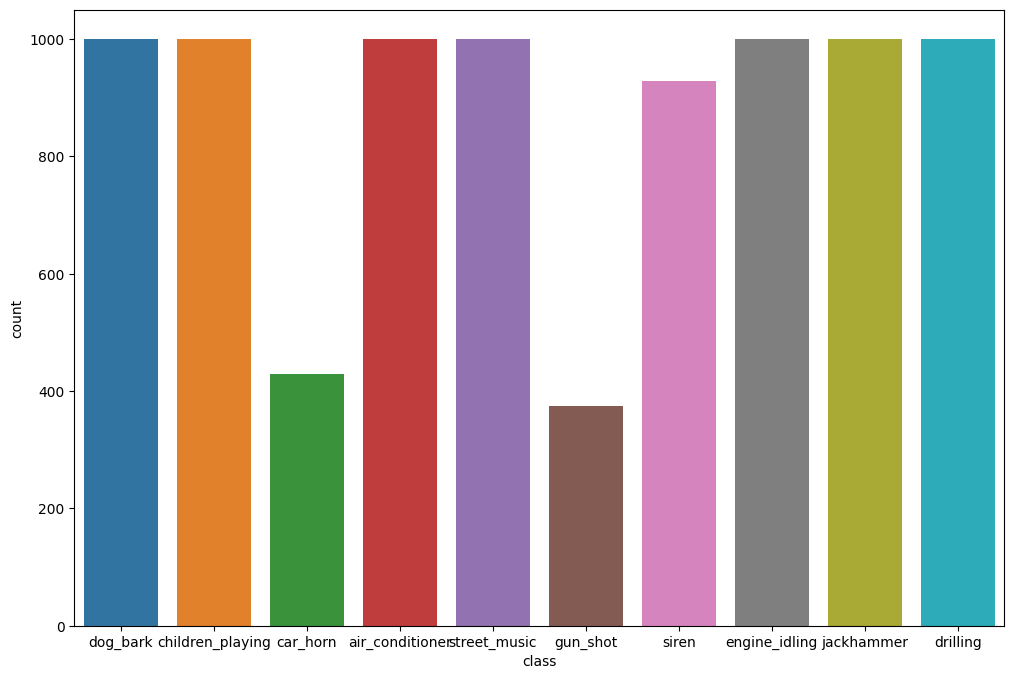

In [19]:
print(extracted_features_df['class'].unique())
fig, ax = plt.subplots(figsize=(12,8)) # genişliği 12 yüksekliği 8 inç bir grafik oluşturmak için
#sns.countplot(extracted_features_df['class'], ax=ax)
sns.countplot(x='class', data=extracted_features_df, ax=ax)
# ax değişkenini kullanarak grafik boyutu, eksen etiketleri, başlık vb. gibi diğer özellikleri de ayarlayabiliriz